# Stock Market Data

In [1]:
# Import libraries and dependencies
import os
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt 
%matplotlib inline

### Load environment variables and import Alpaca keys

In [2]:
# Load the environment variables by calling the load_dotenv function
load_dotenv()

True

In [3]:
# Set Alpaca API key and secret by calling the os.getenv function and referencing the environment variable names
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Check the values were imported correctly by evaluating the type of each
display(type(alpaca_api_key))
display(type(alpaca_secret_key))

str

str

### Setup REST object

In [4]:
# Create an Alpaca API REST object by calling the tradeapi.REST function
# Set the parameters to alpaca_api_key, alpaca_secret_key and api_version="v2" 
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

### Use the Alpaca SDK to make an API call

In [5]:
# Create a list of tickers for traditional (non-crypto) securities
tickers = ["DIA", "NDAQ", "SPY"]

In [6]:
# Use the datetime library (datetime and timedelta) to pull 2 years worth of data from today's date
trading_days = 365
delta = timedelta(days = trading_days*2)

# Set start and end dates for data collection
end_date = datetime.now()
start_date = end_date - delta

# Set to ISO format
start_date = pd.Timestamp(start_date, tz="America/New_York").isoformat()
end_date = pd.Timestamp(end_date, tz="America/New_York").isoformat()

730 days, 0:00:00


'2019-10-08T02:33:14.076058-04:00'

'2021-10-07T02:33:14.076058-04:00'

In [7]:
# Set timeframe to one day (1D)
timeframe = "1D"

# Set number of rows to 1000 to retrieve the maximum amount of rows
limit_rows = 1000

In [8]:
# Use the Alpaca get_barset function to gather the price information for each ticker
stock_prices = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date,
    limit = limit_rows
).df

# Keep only the date component of the DateTime index
stock_prices.index = stock_prices.index.date

# Review the first five rows of the resulting DataFrame 
display(stock_prices.head())
display(stock_prices.tail())

DIA                                           NDAQ          \
                open      high       low     close   volume    open    high   
2019-10-08  262.6400  264.2100  261.3500  261.5763  3062403  98.640  98.640   
2019-10-09  263.4400  264.2400  262.4800  263.4400  1923339  97.970  98.255   
2019-10-10  263.2300  266.0289  263.1100  265.0500  1987784  97.370  98.910   
2019-10-11  267.7699  270.1400  267.6200  268.0800  3904429  99.750  99.830   
2019-10-14  267.6000  268.7300  267.4352  267.8465  1114634  99.095  99.660   

                                      SPY                                      
              low  close   volume    open    high       low   close    volume  
2019-10-08  96.88  97.08  1141451  291.04  291.85  288.4900  288.55  82885280  
2019-10-09  96.89  97.33  1030423  290.75  292.30  290.0600  291.23  49246505  
2019-10-10  97.02  98.54   903836  291.18  294.21  291.0000  293.24  50981567  
2019-10-11  98.24  99.30  1322396  296.27  298.74  296.1448  296.26  83204669  
2019-10-14  98.24  98.32   552517  295.93  296.67  295.5700  296.01  32589599

DIA                                       NDAQ           \
              open      high     low   close   volume    open     high   
2021-09-30  345.08  345.4400  338.11  338.28  7371559  195.10  197.334   
2021-10-01  340.00  344.7800  337.68  343.19  5920343  194.05  194.750   
2021-10-04  342.64  344.0300  338.07  340.00  6743957  193.05  195.330   
2021-10-05  341.15  344.8700  340.47  343.14  3709903  189.42  195.580   
2021-10-06  340.48  344.2999  338.47  344.16  5949679  193.99  195.900   

                                       SPY                            \
               low   close  volume    open      high     low   close   
2021-09-30  192.92  193.02  848464  436.02  436.7700  428.78  429.17   
2021-10-01  190.66  193.84  670129  430.98  436.0329  427.24  434.19   
2021-10-04  188.74  188.94  892987  433.00  433.9600  426.36  428.69   
2021-10-05  189.26  195.26  879657  430.24  435.4900  429.39  433.05   
2021-10-06  192.30  194.58  833930  429.27  435.1199  427.54  434.92   

                       
               volume  
2021-09-30  115315276  
2021-10-01  110774792  
2021-10-04  112134374  
2021-10-05   82381830  
2021-10-06   99477866

### Separate into individual DataFrames that contain only close prices

Dow Jones Industrial Average (DIA)

In [9]:
# Create DataFrame for DIA stock index
dia_prices = stock_prices["DIA"]

# Keep only the close prices and volume
dia_df = dia_prices.drop(columns = ["open", "high", "low"])


# Normalize all metrics by dividing volume by 20,000
dia_df["volume"] = dia_df["volume"] / 20000

# Display first 5 rows
dia_df.head()

,close,volume
2019-10-08,261.5763,153.12015
2019-10-09,263.4400,96.16695
2019-10-10,265.0500,99.38920
2019-10-11,268.0800,195.22145
2019-10-14,267.8465,55.73170


Nasdaq (NDAQ)

In [10]:
# Create DataFrame for NDAQ stock index
ndaq_prices = stock_prices["NDAQ"]

# Keep only the close prices and volume
ndaq_df = ndaq_prices.drop(columns = ["open", "high", "low"])

# Normalize all metrics by dividing volume by 10,000
ndaq_df["volume"] = ndaq_df["volume"] / 10000

# Display first 5 rows
ndaq_df.head()

,close,volume
2019-10-08,97.08,114.1451
2019-10-09,97.33,103.0423
2019-10-10,98.54,90.3836
2019-10-11,99.30,132.2396
2019-10-14,98.32,55.2517


S&P 500 (SPY)

In [11]:
# Create DataFrame for SPY stock index
spy_prices = stock_prices["SPY"]

# Keep only the close prices and volume
spy_df = spy_prices.drop(columns = ["open", "high", "low"])

# Normalize all metrics by dividing volume by 350,000
spy_df["volume"] = spy_df["volume"] / 350000

# Display first 5 rows
spy_df.head()

,close,volume
2019-10-08,288.55,236.815086
2019-10-09,291.23,140.704300
2019-10-10,293.24,145.661620
2019-10-11,296.26,237.727626
2019-10-14,296.01,93.113140


### BOLLINGER BAND STRATEGY

In [12]:
# Create a function that generates custom DataFrames of Bollinger Band metrics (close, sma, lower, upper, volume)
def bollinger(data, window):
    # Create the DataFrame
    bollinger_df = pd.DataFrame()
    
    # Add columns to display close prices and volume from called data
    bollinger_df["close"] = data["close"]
    bollinger_df["volume"] = data["volume"]
    
    # Use the Pandas 'rolling' and 'mean' functions to calculate an SMA based on a given window
    # Add the data to a column called 'sma'
    sma = data["close"].rolling(window = window).mean()
    bollinger_df["sma"] = sma
    
    # Use the Pandas 'rolling' and 'std' functions to calculate a rolling std based on a given window
    # Add the respective data to columns 'lower' and 'upper'  
    std = data["close"].rolling(window = window).std()
    bollinger_df["lower"] = sma - std * 2
    bollinger_df["upper"] = sma + std * 2
    
    print(f"Data is based on a {window}-day SMA.")
    
    return bollinger_df

In [13]:
# Generate a Bollinger Band DataFrame for SPY. Play around with differetn values for 'window'.
spy_bb = bollinger(spy_df, 20)

# Display DataFrame
display(spy_bb.head())
display(spy_bb.tail())

Data is based on a 20-day SMA.


,close,volume,sma,lower,upper
2019-10-08,288.55,236.815086,NaN,NaN,NaN
2019-10-09,291.23,140.704300,NaN,NaN,NaN
2019-10-10,293.24,145.661620,NaN,NaN,NaN
2019-10-11,296.26,237.727626,NaN,NaN,NaN
2019-10-14,296.01,93.113140,NaN,NaN,NaN


,close,volume,sma,lower,upper
2021-09-30,429.17,329.472217,443.14925,428.753265,457.545235
2021-10-01,434.19,316.499406,442.19900,428.088889,456.309111
2021-10-04,428.69,320.383926,440.98050,426.612851,455.348149
2021-10-05,433.05,235.376657,440.05700,426.175592,453.938408
2021-10-06,434.92,284.222474,439.25500,426.196885,452.313115


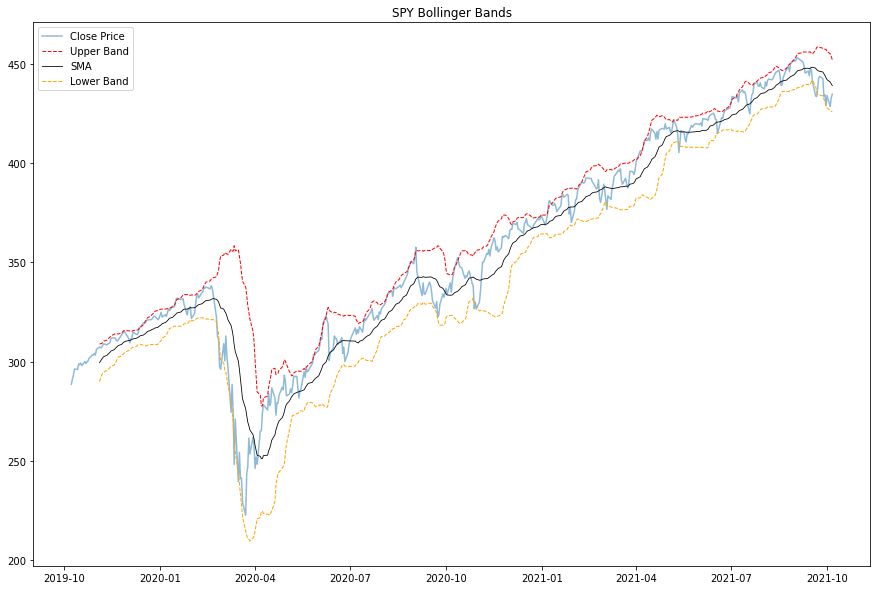

In [58]:
# Plot the DataFrame to visualize the SMA and Bollinger Bands using axes objects (ax=ax)
ax = spy_bb["close"].plot(
    figsize = (15,10),
    title = "SPY Bollinger Bands",
    alpha = 0.5, 
    linewidth = 1.5
)

# Overlay each column as a separate line on the same plot
spy_bb["upper"].plot(ax=ax, linestyle = "--", linewidth = 1, color = "red")
spy_bb["sma"].plot(ax=ax, linestyle = "-", linewidth = .8, color = "black")
spy_bb["lower"].plot(ax=ax, linestyle = "--", linewidth = 1, color = "orange")
#spy_bb["volume"].plot(ax=ax)

# Call the legend for the plot
ax.legend(["Close Price", "Upper Band", "SMA", "Lower Band"])


In [15]:
# # Generate a Bollinger Band DataFrame for NDAQ. Play around with differetn values for 'window'.
# ndaq_bb = bollinger(ndaq_df, 20)

# # Display DataFrame
# ndaq_bb

In [16]:
# # Plot the DataFrame to visualize the SMA and Bollinger Bands
# ndaq_bb.plot(figsize=(25,10))

In [17]:
# # Generate a Bollinger Band DataFrame for NDAQ. Play around with differetn values for 'window'.
# dia_bb = bollinger(dia_df, 20)

# # Display DataFrame
# dia_bb

In [18]:
# # Plot the DataFrame to visualize the SMA and Bollinger Bands
# dia_bb.plot(figsize=(25,10))

In [19]:
def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

In [20]:
buy_price, sell_price, bb_signal = implement_bb_strategy(spy_bb["close"], spy_bb["lower"], spy_bb["upper"])

strategy_df = pd.DataFrame()
strategy_df["close"] = spy_bb["close"]

strategy_df["buy_price"] = buy_price
strategy_df["sell_price"] = sell_price
strategy_df["bb_signal"] = bb_signal

display(strategy_df.head())
display(strategy_df.tail())

,close,buy_price,sell_price,bb_signal
2019-10-08,288.55,NaN,NaN,0
2019-10-09,291.23,NaN,NaN,0
2019-10-10,293.24,NaN,NaN,0
2019-10-11,296.26,NaN,NaN,0
2019-10-14,296.01,NaN,NaN,0


,close,buy_price,sell_price,bb_signal
2021-09-30,429.17,NaN,NaN,0
2021-10-01,434.19,NaN,NaN,0
2021-10-04,428.69,NaN,NaN,0
2021-10-05,433.05,NaN,NaN,0
2021-10-06,434.92,NaN,NaN,0


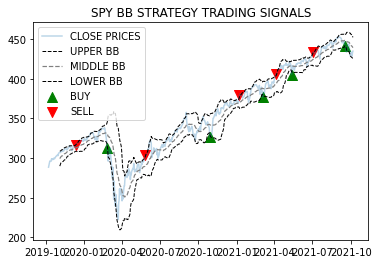

<Figure size 1800x720 with 0 Axes>

In [21]:
spy_bb['close'].plot(label = 'CLOSE PRICES', alpha = 0.3)
spy_bb['upper'].plot(label = 'UPPER BB', linestyle = '--', linewidth = 1, color = 'black')
spy_bb['sma'].plot(label = 'MIDDLE BB', linestyle = '--', linewidth = 1.2, color = 'grey')
spy_bb['lower'].plot(label = 'LOWER BB', linestyle = '--', linewidth = 1, color = 'black')

plt.scatter(spy_bb.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 100)
plt.scatter(spy_bb.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 100)
plt.title('SPY BB STRATEGY TRADING SIGNALS')
plt.legend(loc = 'upper left')

plt.figure(figsize=(25,10))

plt.show()